# ST-HDBSCAN: Spatiotemporal Hierarchical DBSCAN for Trajectory Data

## Abstract

The study of human mobility has advanced greatly in recent years due to the availability of
commercial large-scale GPS trajectory datasets [3]. However, the validity of findings that use
these datasets depends heavily on the robustness of their pre-processing methods. An important
step in the processing of mobility data is the detection of stops within GPS trajectories, for
which many clustering algorithms have been proposed [4, 8, 6, 1]. Yet, the high sparsity of
commercial GPS data can affect the performance of these stop-detection algorithms.
In the case of DBSCAN, while it initially identifies dense regions, it can often over-cluster
or under-cluster due to noise and weakly connected points given the chosen ε. ST-DBSCAN [4]
uses two distance thresholds, Eps1 for spatial and Eps2 for non-spatial values. The algorithm
compares the average non-spatial value, such as temperature, of a cluster with a new com-
ing value, to prevent merging adjacent clusters. Nevertheless, datasets that include this kind
of information are not comparable to realistic GPS-based trajectories. A promising algorithm
is T-DBSCAN [6], which searches forward in time for a continuous density-based neighbor-
hood of core points. Points spatially close, within Eps, and within a roaming threshold, CEps, are included in a cluster. Additionally, we used a time-augmented DBSCAN algorithm, TA-DBSCAN, which recursively processes the clusters obtained from DBSCAN to address the issue of initial clusters overlapping in time. However, methods [9] that validate stop-detection algorithms based on synthetic data show that these can omit, merge, or split stops based on the selection of epsilon and sparsity of the data.

If we define parameters that may be considered fine (low ε), it might completely miss a stop at a larger location. In contrast, coarse parameters (large ε) may struggle to differentiate stops within small neighboring locations [3]. Since different venues vary in stop durations and areas, this could influence the parameter choices [9]. To address this parameter selection limitation, we propose a spatiotemporal variation of Hierarchical DBSCAN [5], ST-HDBSCAN. Unlike DBSCAN, which relies on one threshold of density to cluster points, our variation constructs separate structures for space and time distances that preserve density-based connections in these two dimensions. This approach ensures that when pruning the hierarchical tree structure needed for cluster formation, we account for varying spatiotemporal densities. As a result, clusters emerge naturally without requiring specific time and space thresholds, working effectively across different data sparsity levels.

In [113]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [350]:
import pandas as pd
import numpy as np
from datetime import timedelta
import pygeohash as gh
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Transformer
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [115]:
import nomad.io.base as loader
import nomad.constants as constants
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.filters as filters
import nomad.city_gen as cg

In [116]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

data = loader.from_file("../../nomad/data/gc_sample.csv")

In [117]:
# We create a time offset column with different UTC offsets (in seconds)
data['tz_offset'] = 0
data.loc[data.index[:5000],'tz_offset'] = -7200
data.loc[data.index[-5000:], 'tz_offset'] = 3600

# create datetime column as a string
data['local_datetime'] = loader._unix_offset_to_str(data.timestamp, data.tz_offset)
data['local_datetime'] = pd.to_datetime(data['local_datetime'], utc=True)

# create x, y columns in web mercator
gdf = gpd.GeoSeries(gpd.points_from_xy(data.longitude, data.latitude),
                        crs="EPSG:4326")
projected = gdf.to_crs("EPSG:3857")
data['x'] = projected.x
data['y'] = projected.y

In [118]:
data

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,-7200,2024-01-01 14:29:00+00:00,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,-7200,2024-01-01 14:35:00+00:00,-4.081792e+06,4.624968e+06
2,wizardly_joliot,1704155880,38.320959,-36.666748,-7200,2024-01-02 00:38:00+00:00,-4.081724e+06,4.624866e+06
3,wizardly_joliot,1704156000,38.320936,-36.666739,-7200,2024-01-02 00:40:00+00:00,-4.081723e+06,4.624863e+06
4,wizardly_joliot,1704156840,38.320924,-36.666747,-7200,2024-01-02 00:54:00+00:00,-4.081724e+06,4.624861e+06
...,...,...,...,...,...,...,...,...
25830,angry_spence,1705303380,38.320399,-36.667438,3600,2024-01-15 07:23:00+00:00,-4.081801e+06,4.624787e+06
25831,angry_spence,1705303740,38.320413,-36.667469,3600,2024-01-15 07:29:00+00:00,-4.081804e+06,4.624789e+06
25832,angry_spence,1705303980,38.320384,-36.667455,3600,2024-01-15 07:33:00+00:00,-4.081802e+06,4.624785e+06
25833,angry_spence,1705304340,38.320349,-36.667473,3600,2024-01-15 07:39:00+00:00,-4.081804e+06,4.624780e+06


In [119]:
user_sample = data.loc[data.uid == "angry_spence"]
user_sample = user_sample[['timestamp', 'x', 'y']]

In [211]:
user_sample

,timestamp,x,y
24139,1704104460,-4.081702e+06,4.624871e+06
24140,1704104820,-4.081697e+06,4.624867e+06
24141,1704104940,-4.081696e+06,4.624866e+06
24142,1704105540,-4.081698e+06,4.624865e+06
24143,1704105720,-4.081699e+06,4.624866e+06
...,...,...,...
25830,1705303380,-4.081801e+06,4.624787e+06
25831,1705303740,-4.081804e+06,4.624789e+06
25832,1705303980,-4.081802e+06,4.624785e+06
25833,1705304340,-4.081804e+06,4.624780e+06


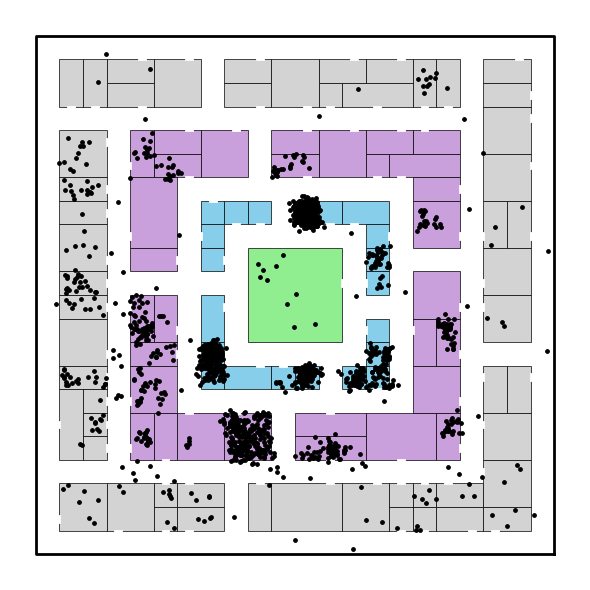

In [121]:
%matplotlib inline

plot_df = data.loc[data.uid == "angry_spence"].copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['latitude'].values, plot_df['longitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [340]:
time_pairs = HDBSCAN._find_bursts(user_sample['timestamp'], 14)
core_distances = _compute_core_distance(user_sample, time_pairs, 4)
mrd = HDBSCAN._compute_mrd_graph(user_sample, core_distances)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = mst_ext(mst_edges, core_distances)

In [251]:
mst_ext_df = mstext_edges
min_cluster_size = 2

In [344]:
# Synthetic dataset with connected 2 components connected by an edge with weight infinity
def synthetic_graph_with_cc():
    # Cluster A: points around (0, 0)
    cluster_a = pd.DataFrame({
        'timestamp': [1, 2, 3],
        'x': [0, 0.1, -0.1],
        'y': [0, 0.1, -0.1]
    })

    # Cluster B: points around (10, 10)
    cluster_b = pd.DataFrame({
        'timestamp': [4, 5, 6],
        'x': [10, 10.1, 9.9],
        'y': [10, 9.9, 10.1]
    })

    traj = pd.concat([cluster_a, cluster_b], ignore_index=True)

    # MST edges within cluster A
    edges_a = [(1, 2, 0.15), (2, 3, 0.20)]
    # MST edges within cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.19)]
    # Artificial high-weight edge between cluster A and B
    bridge_edge = [(3, 4, np.inf)]

    # Combine into full MST+ext
    mst_ext_df = pd.DataFrame(edges_a + edges_b + bridge_edge, columns=["from", "to", "weight"])

    return mst_ext_df

In [352]:
mst_ext_df = synthetic_graph_with_cc()
mst_ext_df

,from,to,weight
0,1,2,0.15
1,2,3,0.20
2,4,5,0.10
3,5,6,0.19
4,3,4,inf


In [356]:
def visualize_mst(mst_df):
    G = nx.Graph()

    for u, v, w in mst_ext_df.itertuples(index=False):
        w_val = 1e6 if np.isinf(w) else w
        inv_w = 1.0 / w_val if w_val > 0 else 0.001
        label = "∞" if np.isinf(w) else f"{w:.2f}"
        G.add_edge(u, v, weight=w_val, inv_weight=inv_w, label=label)

    # Use inverse weights for layout
    pos = nx.spring_layout(G, weight='inv_weight')

    # Retrieve edge labels from edge attributes
    edge_labels = nx.get_edge_attributes(G, 'label')

    # Plot
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("MST Extended Graph with Edge Weights")
    plt.axis('off')
    plt.show()

def visualize_adjacency_dict(G_dict):
    """
    Visualize an adjacency dictionary as a NetworkX graph.

    Parameters
    ----------
    G_dict : dict
        Output of _build_graph() — {node: set(neighbors)}
    """
    # Convert dict-of-sets into a networkx Graph
    G = nx.Graph()
    for u, neighbors in G_dict.items():
        for v in neighbors:
            G.add_edge(u, v)

    print(G.number_of_nodes())

    pos = nx.spring_layout(G, seed=42)

    # Draw graph
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightgreen',
        edge_color='gray',
        node_size=200,
        font_size=10
    )
    plt.title("Connected Component After Edge Removal")
    plt.tight_layout()
    plt.show()

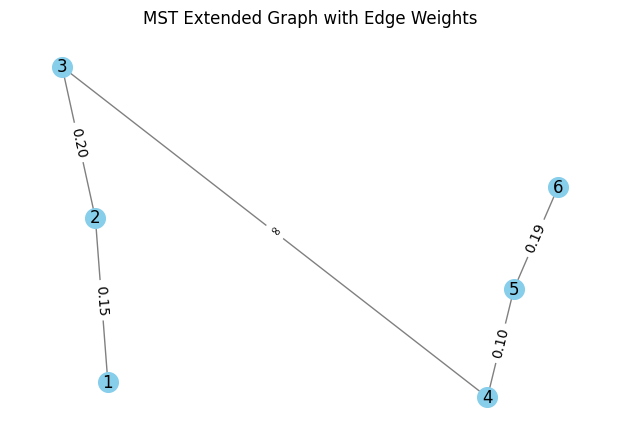

In [355]:
visualize_mst(mst_ext_df)

In [361]:
label_history_df = hdbscan(mst_ext_df, min_cluster_size)

In [363]:
label_history_df[label_history_df['timestamp'] == 3]

,timestamp,cluster_id,dendrogram scale
2,3,0,NaN
8,3,1,inf
14,3,-1,0.20
20,3,-1,0.19
26,3,-1,0.15
32,3,-1,0.10


- para cada label y para cada node del label, coger el 1st dendrogram scale and the last one
- change col names: cluster_id, lambda_min

- λ_min(Ci): minimum density level at which Ci exists
    - ε_max(Ci): maximum ε value at which Ci exisits
- λ_max(xj,Ci): the density level beyond which object xj no longer belongs to cluster Ci
    - ε_min(xj , Ci): ε value beyond which object xj no longer belongs to cluster Ci

In [252]:
def _compute_cluster_stability(hierarchy, cluster_memberships, timestamps):
    """
    Compute the stability of each cluster using inverse epsilon (1/ε) formulation.

    Parameters
    ----------
    hierarchy : list of tuples
        Each tuple is (epsilon_threshold, parent_cluster_id, [child_cluster_ids]).
    cluster_memberships : dict
        Mapping from cluster_id to set of timestamps (points).
    timestamps : iterable
        All unique timestamps.

    Returns
    -------
    stability : dict
        {cluster_id: stability score}
    """
    lambda_min = {0: float('inf')}  # ε_min for each cluster
    lambda_max = {}  # ε_max (i.e., distance at which point leaves cluster)

    # Track membership evolution per point
    membership = defaultdict(list)  # timestamp: [(cluster_id, exit_epsilon)]

    # Initially all points are in cluster 0
    for ts in timestamps:
        membership[ts].append((0, None))

    for eps, parent_id, child_ids in hierarchy:
        # Record when parent stops existing
        lambda_max[parent_id] = eps
        # Children begin to exist at this eps
        for child_id in child_ids:
            lambda_min[child_id] = eps
            for ts in cluster_memberships.get(child_id, set()):
                membership[ts].append((child_id, None))

        # For all points still in parent that weren’t reassigned to a child, record their exit
        for ts, evolution in membership.items():
            for i, (cid, exit_eps) in enumerate(evolution):
                if cid == parent_id and exit_eps is None:
                    evolution[i] = (cid, eps)

    # Compute stability using inverse epsilon formulation
    stability = defaultdict(float)
    for ts in timestamps:
        for cid, exit_eps in membership[ts]:
            if cid not in lambda_min:
                continue
            eps_min = lambda_min[cid]
            eps_max = exit_eps if exit_eps is not None else lambda_max.get(cid, eps_min)
            if eps_max > eps_min:  # only contribute if point truly stayed for some duration
                stability[cid] += (1.0 / eps_min) - (1.0 / eps_max)

    return dict(stability)

In [242]:
from collections import defaultdict

def _compute_cluster_stability(hierarchy, cluster_memberships, timestamps):
    """
    Compute the stability of each cluster from the hierarchy.

    Parameters
    ----------
    hierarchy : list of tuples
        Each tuple is (scale, parent_cluster_id, [child_cluster_ids]).
    label_map : dict
        Final label mapping of each timestamp.
    timestamps : set
        All unique timestamps.

    Returns
    -------
    stability : dict
        {cluster_id: stability score}
    """
    lambda_min = {0: 0.0} # λ_min(Ci) is the minimum density level at which Ci exists
    lambda_max = {} # λ_max(xj,Ci) is the density level beyond which object xj no longer belongs to cluster Ci
    
    # Track which cluster each timestamp was in at which scale
    membership = defaultdict(list)  # timestamp: [(cluster_id, scale_exit)]

    # Initially all points are in cluster 0
    for ts in timestamps:
        membership[ts].append((0, None))

    for scale, parent_id, child_ids in hierarchy:
        lambda_max[parent_id] = scale
        for child_id in child_ids:
            lambda_min[child_id] = scale
            for ts in cluster_memberships.get(child_id, set()):
                membership[ts].append((child_id, None))

        # For all points that were in the parent cluster, but not reassigned to a child
        for ts, cluster_list in membership.items():
            for i, (cid, exit_scale) in enumerate(cluster_list):
                if cid == parent_id and exit_scale is None:
                    cluster_list[i] = (cid, scale)

    final_scale = max(lambda_max.values(), default=0.0) + 1.0
    
    for ts in timestamps:
        for i, (cid, exit_scale) in enumerate(membership[ts]):
            if exit_scale is None:
                membership[ts][i] = (cid, final_scale)

    # Stability : S(Ci)= Σx_j ∈ C_i {λ_max(xj,Ci) − λ_min(Ci)}
    stability = defaultdict(float)
    
    for ts in timestamps:
        for cid, exit_scale in membership[ts]:
            birth = lambda_min.get(cid, 0.0) # λ_min(Ci)
            death = exit_scale
            if death > birth:
                stability[cid] += death - birth # λ_max(xj,Ci) − λ_min(Ci)
    
    return dict(stability)

In [248]:
from collections import defaultdict

def _select_stable_clusters(hierarchy, stability):
    """
    Select stable clusters using the bottom-up recursive optimization from the HDBSCAN paper.

    Parameters
    ----------
    hierarchy : list of (scale, parent_cluster_id, [child_cluster_ids])
    stability : dict mapping cluster_id -> stability score

    Returns
    -------
    selected_clusters : set of cluster_ids selected in the flat clustering
    """
    children = defaultdict(list)
    parent = {}

    for _, p, kids in hierarchy:
        for k in kids:
            children[p].append(k)
            parent[k] = p

    all_clusters = set(stability) | set(children) | set(parent)

    # Detect root (cluster with no parent)
    root_candidates = all_clusters - set(parent.keys())
    root = min(root_candidates) if root_candidates else 0

    best_stability = {}
    selected_clusters = set()

    def recurse(cid):
        if cid not in children:
            best_stability[cid] = stability.get(cid, 0.0)
            return best_stability[cid]

        child_stab_sum = sum(recurse(k) for k in children[cid])
        own_stab = stability.get(cid, 0.0)

        if own_stab >= child_stab_sum:
            best_stability[cid] = own_stab
            for k in children[cid]:
                selected_clusters.discard(k)
            selected_clusters.add(cid)
        else:
            best_stability[cid] = child_stab_sum

        return best_stability[cid]

    print(f"Root: {root}")
    print(f"Stability[root]: {stability.get(root)}")

    for cid in children[root]:
        print(f"Child {cid} stability: {stability.get(cid)}")
        recurse(cid)

    return selected_clusters

In [150]:
def _hdbscan_labels(label_map, final_clusters):
    """
    Assign final labels to each timestamp based on selected stable clusters.
    
    Parameters
    ----------
    label_map : dict
        {Original timestamp: cluster_id mapping}
    final_clusters : set
        Set of selected cluster IDs.

    Returns
    -------
    final_labels : dict
        {timestamp: final cluster label (-1 if noise)}
    """
    final_labels = {}
    
    for ts, cid in label_map.items():
        if cid in final_clusters:
            final_labels[ts] = cid
        else:
            final_labels[ts] = -1  # noise

    return final_labels